# Make orthogonal cross sections 

In [19]:
import cloudComPy as cc

import os
import numpy as np

import matplotlib.pyplot as plt

from yaml import load
from yaml.loader import Loader

from tqdm import tqdm
from helpers.utils import computePolygonArea

In [21]:
# load the point cloud 
PROCESSING_FILEPATH = "../../sample_data/SampleCave/processing_params.yml"

p = load(open(PROCESSING_FILEPATH), Loader)

root = "../../sample_data/SampleCave/"


One idea would be to fit a plane and sample cloud distance along that plane, then only threshold. 
Second is to calculate the envelope in a rotated cloud. 
To get the enveloppe, we would need to calculate a rotation matrix from a normalised vector to vector ? 

In [22]:
def toYParallelMatrix(vec):
    # calculate vector norm 
    norm = vec / np.sqrt(np.sum(vec**2))

    transmat = cc.ccGLMatrix.FromToRotation(list(norm),[0,1,0]) # from Y parallel to Z parallel
    return transmat

In [23]:
def translationToMatrix(vec):
    transmat = np.diag(np.ones(4))
    transmat[:3,3] = vec
    
    transmat = cc.ccGLMatrix(transmat.T.flatten())

    return transmat

In [24]:
# load the different polyline elements. 
CENTRELINE_FILEPATH = os.path.join(root, "output/CentreLine.poly")
GLOBAL_SHIFT = p["alignment"]["globalShift"]
centreline = np.loadtxt(CENTRELINE_FILEPATH) + GLOBAL_SHIFT

In [42]:
vecs = centreline[10:] - centreline[:-10]

In [43]:
sampleCloud = cc.loadPointCloud( os.path.join(root, p["paths"]["subsampledCut2DOutCloudName"]), cc.CC_SHIFT_MODE.XYZ, 0, *GLOBAL_SHIFT)

In [44]:
section_cloud = cc.ccPointCloud()
section_cloud.coordsFromNPArray_copy(np.array([[-20, 0, 20],[0,0,20], [20,0,20]]))
cut_section_polyline = cc.ccPolyline(section_cloud)
cut_section_polyline.addChild(section_cloud)
cut_section_polyline.addPointIndex(0, section_cloud.size())
cut_section_polyline.setName("section")
cut_section_polyline.setClosed(True)
cut_section_polyline.setGlobalShift(*GLOBAL_SHIFT)

In [45]:
cut_section_polyline.getBoundingBox()

[(-20.0, 0.0, 20.0), (20.0, 0.0, 20.0)]

In [46]:
slices = []
envelopes =[]

In [47]:
total_iterations = len(vecs)
for n,vec in tqdm(enumerate(vecs), total = total_iterations):
    # make a plane orthogonal to the Y axis. 
    # first we need a rotation of 90 degrees from Y axis towards the Z axis. 

    tr90 = cc.ccGLMatrix.FromToRotation((0,1,0),(0,0,1))
    
    tr = toYParallelMatrix(vec)
    orig = centreline[n+2]
    translation = translationToMatrix(orig)

    # conceptually. apply transformation to point cloud. 
    # extract a section from a polyline Should be orthogonal to the Yparallel vector, hence possibly just 
    # should the translation also be added ??? 
    # save as a numpy array for the polyline in local coordinates. 
    # apply inverse transformation to the cloud ? 
    mpx = cc.ccGLMatrix(translation*tr.inverse()*tr90)
    mpx2 = cc.ccGLMatrix(translation*tr.inverse()).inverse()
    plane = cc.ccPlane(15, 15, mpx)
    ret = cc.SaveMesh(plane,os.path.join(root, f"process/Plane{n}.stl"))
    params = cc.Cloud2MeshDistancesComputationParams()
    params.signedDistances = True
    params.octreeLevel = 8

    ret = cc.DistanceComputationTools.computeCloud2MeshDistances(sampleCloud, plane, params)
    sampleCloud.setCurrentScalarField(1)

    sf = sampleCloud.getScalarField(1).toNpArrayCopy()
    slice = sampleCloud.filterPointsByScalarValue(minVal = -0.2, maxVal = 0.2, outside = False)

    sampleCloud.deleteScalarField(1)
    slice.applyRigidTransformation(mpx2)
    slices.append(slice)


100%|████████████████████████████████████████████████████████████████████████████████| 164/164 [03:41<00:00,  1.35s/it]


IndexError: list index out of range

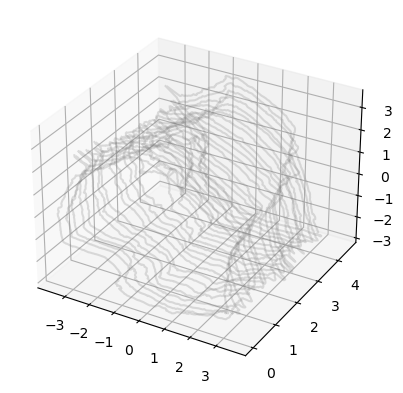

In [37]:
fig = plt.figure()
areas = np.zeros(len(slices))
perimeters = np.zeros(len(slices))

ax = fig.add_subplot(111, projection ="3d")
for n, slice in enumerate(slices):
    out = cc.extractPointsAlongSections([slice], [cut_section_polyline], defaultSectionThickness = 0.1, envelopeMaxEdgeLength = 0.1, extractSectionsAsEnvelopes=True, vertDim = 2, 
                             s_extractSectionsType = cc.EnvelopeType.ENV_FULL)
    section  = out[0].getAssociatedCloud().toNpArrayCopy()
    perimeters[n] = out[0].computeLength()
    x = section[:,0]
    y = section[:,2]
    
    areas[n] = computePolygonArea(x, y)
    ax.plot(section[:,0], np.ones(section.shape[0])*n / 35  * 8, section[:,2],  color = "grey", alpha = 0.25)

plt.show()

In [38]:
Dh = 4 *areas / perimeters

xi = centreline[2:-2,1]

C:\Users\racinet\AppData\Local\Temp\ipykernel_15496\1570580297.py:1: RuntimeWarning: invalid value encountered in true_divide
  Dh = 4 *areas / perimeters


ValueError: x and y must have same first dimension, but have shapes (170,) and (191,)

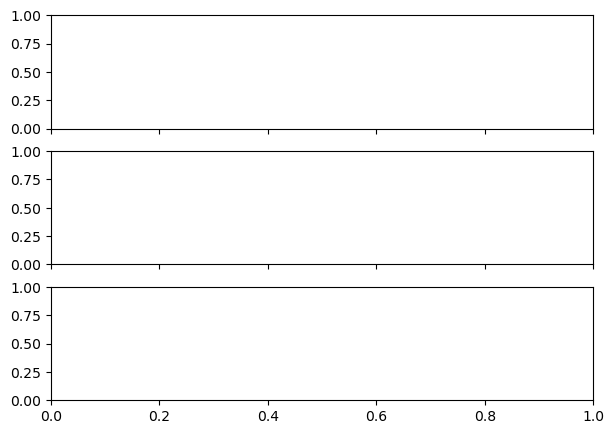

In [39]:
fig, axes = plt.subplots(3, 1, figsize= (7, 5), sharex = True)

axes[0].plot(xi, areas , label = "area")
axes[0].set_ylabel("$A$ [m$^2$]")
#axes[0].text(10, 16, f"$\\bar{{A}}$ = {np.mean(areas[2:-4][15:]):.0f} $\pm${np.std(areas[2:-4][15:]):.0f}")
#axes[0].text(90, 29, f"$\\bar{{A}}$ = {np.mean(areas[2:-4][:15]):.0f} $\pm${np.std(areas[2:-4][:15]):.0f}")
axes[0].set_ylim(13, 37)


axes[1].plot(xi,perimeters, label= "perimeter")
axes[1].set_ylabel("$P$ [m]")
axes[1].set_ylim(14, 46)


axes[2].plot(xi,Dh, label = "Dh")
axes[2].set_ylabel("$D_H$ [m]")
#axes[2].text(10, 2.5, f"$\\bar{{D_H}}$ = {np.mean(Dh[25:]):.1f} $\pm${np.std(Dh[25:]):.1f}")
#axes[2].text(85, 4, f"$\\bar{{D_H}}$ = {np.mean(Dh[:25]):.1f} $\pm${np.std(Dh[:25]):.1f}")
axes[2].set_ylim(1.2, 5.8)

axes[2].set_xlabel("y [m]")


for ax in axes:
    ax.grid()
    #ax.axvline(len(areas[2:-4])-15, ls = "--", color = "firebrick")
plt.tight_layout()

